✅ Figure saved: ../outputs/figures\Stacked_Ensemble_Actual_vs_Predicted.png


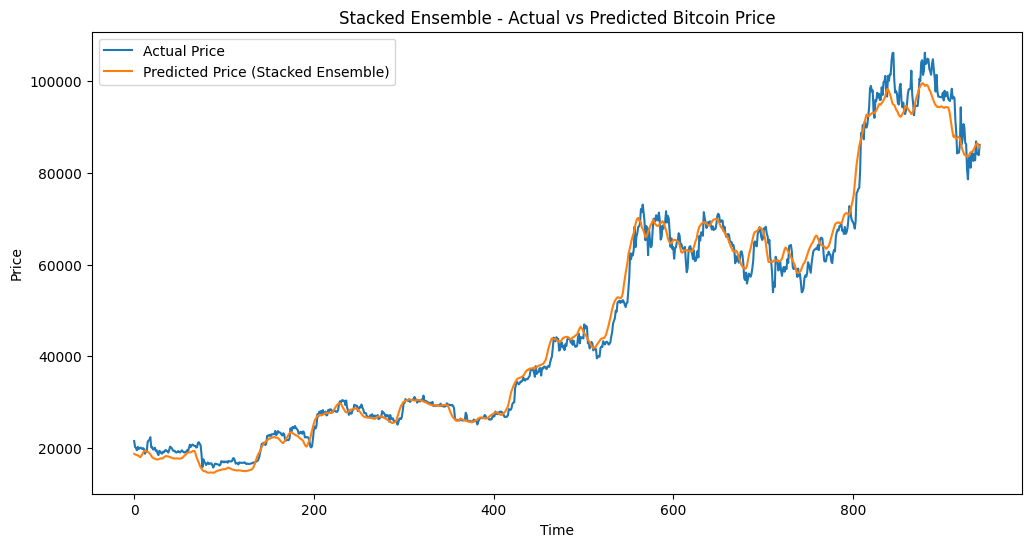

📋 Stacked Ensemble Evaluation Metrics:
   MAE: 1891.3836
   MSE: 6777980.8119
   RMSE: 2603.4556
   R²: 0.9899
✅ Stacked ensemble model saved to ../models/stacked_ensemble_model.pkl


In [1]:
# 08_modeling_stacking_ensemble.ipynb

import sys
sys.path.append('../src')
from utils import save_fig
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --------------------------
# 📁 Paths
# --------------------------
outputs_dir = '../outputs/metrics'
figures_dir = '../outputs/figures'
models_dir = '../models'

# --------------------------
# 📥 Load Base Model Predictions
# --------------------------
arima = pd.read_csv(os.path.join(outputs_dir, 'ARIMA_predictions.csv'))
sarima = pd.read_csv(os.path.join(outputs_dir, 'SARIMA_predictions.csv'))
lstm = pd.read_csv(os.path.join(outputs_dir, 'LSTM_predictions.csv'))
bilstm = pd.read_csv(os.path.join(outputs_dir, 'BiLSTM_predictions.csv'))

# Standardize column names if needed
for df in [arima, sarima, lstm, bilstm]:
    df.columns = ['Date', 'Actual', 'Predicted'] if 'Actual_Price' not in df.columns else ['Date', 'Actual', 'Predicted']

# --------------------------
# 🔗 Merge All Predictions on Date
# --------------------------
merged = arima[['Date', 'Actual']].copy()
merged['ARIMA'] = arima['Predicted']
merged['SARIMA'] = sarima['Predicted']
merged['LSTM'] = lstm['Predicted']
merged['BiLSTM'] = bilstm['Predicted']

# --------------------------
# 🤖 Stacking: Train Meta-Learner
# --------------------------
# Drop rows with any NaNs in prediction columns
stack_df = merged[['ARIMA', 'SARIMA', 'LSTM', 'BiLSTM', 'Actual']].dropna()

X = stack_df[['ARIMA', 'SARIMA', 'LSTM', 'BiLSTM']]
y = stack_df['Actual']

meta_learner = LinearRegression()
meta_learner.fit(X, y)

# Predict using cleaned data
merged = merged.dropna(subset=['ARIMA', 'SARIMA', 'LSTM', 'BiLSTM'])
merged['Predicted_Price'] = meta_learner.predict(merged[['ARIMA', 'SARIMA', 'LSTM', 'BiLSTM']])


# --------------------------
# 💾 Save CSV
# --------------------------
stacked_preds = merged[['Date', 'Actual', 'Predicted_Price']]
stacked_preds.columns = ['Date', 'Actual_Price', 'Predicted_Price']
stacked_preds.to_csv(os.path.join(outputs_dir, 'Stacked_Ensemble_predictions.csv'), index=False)

# --------------------------
# 📊 Plotting
# --------------------------
plt.figure(figsize=(12,6))
plt.plot(stacked_preds['Actual_Price'], label='Actual Price')
plt.plot(stacked_preds['Predicted_Price'], label='Predicted Price (Stacked Ensemble)')
plt.title('Stacked Ensemble - Actual vs Predicted Bitcoin Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
save_fig("Stacked_Ensemble_Actual_vs_Predicted")
plt.show()

# --------------------------
# 📈 Evaluation Metrics
# --------------------------
y_true = stacked_preds['Actual_Price']
y_pred = stacked_preds['Predicted_Price']

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"📋 Stacked Ensemble Evaluation Metrics:")
print(f"   MAE: {mae:.4f}")
print(f"   MSE: {mse:.4f}")
print(f"   RMSE: {rmse:.4f}")
print(f"   R²: {r2:.4f}")

# --------------------------
# 💾 Save Final Model
# --------------------------
joblib.dump(meta_learner, os.path.join(models_dir, 'stacked_ensemble_model.pkl'))
print("✅ Stacked ensemble model saved to ../models/stacked_ensemble_model.pkl")
